In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import Tensor
import functools
import os
import numpy as np

import warnings
import glob


import io
from joblib import delayed 

from cacher import root, file_cached, mem_cached, clear_cache

import pymorphy2

from corus import load_lenta2
from navec import Navec
from razdel import tokenize, sentenize
from nerus import load_nerus

from utils import ProgressParallel, chunks, size_of_tensor, count_parameters
from joblib import delayed

from utils import download_file

from slovnet.model.emb import NavecEmbedding

# from torchmetrics.functional.classification import binary_accuracy

import random
import string

from pymorphy2.tagset import OpencorporaTag
from params import NO_PUNCT, build_params
morph = pymorphy2.MorphAnalyzer()

# https://pymorphy2.readthedocs.io/en/stable/user/grammemes.html
# http://opencorpora.org/dict.php?act=gram
# https://github.com/pymorphy2/pymorphy2/blob/92d546f042ff14601376d3646242908d5ab786c1/pymorphy2/tagset.py#L130
feature_tags_array = [
    OpencorporaTag.PARTS_OF_SPEECH, # часть речи
    OpencorporaTag.GENDERS, # род
    OpencorporaTag.NUMBERS, # число
    OpencorporaTag.CASES, # падеж
    OpencorporaTag.ASPECTS, # соверш / несоверш
    OpencorporaTag.TRANSITIVITY, # перех / непереходный
    OpencorporaTag.PERSONS, # лицо
    OpencorporaTag.TENSES, # время
    OpencorporaTag.MOODS, # наклонение
    OpencorporaTag.VOICES, # залог
    #INVOLVEMENT
    ['Prnt'], # вводные слова
    ['Apro'], # местоимение
    ['NUMB'], # число вида 1234
    ['LATIN'], # текст на английском
    ['UNKN'], # неизвестный токен
    ['PUNCT_DASH', 'PUNCT_DOT', 'PUNCT_COMMA', 'PUNCT_QUOTE',
     'PUNCT_LEFT_PARENTHESIS', 'PUNCT_RIGHT_PARENTHESIS' ], # "()
    ['CAPITALIZED'], # начинается с заглавной буквы
    ['Fixd', 'Abbr'] # неизменяемое, сокращение
]

CUT_NAVEC_TAGS_ARRAY = [
    #'NOUN', #'ADJF'
]

params = build_params({
    "VARIANTS_CNT": 1,
    "TARGET_CLASSES_COUNT": 3,
    "INPUT_WORDS_CNT": 16,
    "feature_tags_array": feature_tags_array,
    "PUNCTUATION_TARGET": {
        "$empty": NO_PUNCT,
        ",": 1,
        ".": 2,
        "!": 2,
        "?": 2,
    },
    "USE_NAVEC": True,
    'CUT_NAVEC_TAGS_SET': set(CUT_NAVEC_TAGS_ARRAY),
    'INFECTED_TEXT_PROB': 0.1,
    "RETAIN_LEFT_PUNCT": True,
})
torch.cuda.is_available(), torch.rand(10).to('cuda:0')


(True,
 tensor([0.9213, 0.0045, 0.9024, 0.6469, 0.8558, 0.0306, 0.0451, 0.8568, 0.2471,
         0.1295], device='cuda:0'))

In [2]:
import dataset_builder 
import importlib
importlib.reload(dataset_builder) 
dataset_builder.get_word_features('кошка', params).shape

torch.Size([354])

In [16]:
import gc
gc.collect()

0

In [2]:
import dataset_lib
import importlib
importlib.reload(dataset_lib)


params['type'] = 'lenta'
dataset = dataset_lib.Dataset(params, train_test_split=0.9, chunk_size=300000, batch_size=2000)
dataset.load(50000, 10000) # 50000
dataset.to_gpu()


part [0/50000]


  0%|          | 0/10000 [00:00<?, ?it/s]

part [10000/50000]


  0%|          | 0/10000 [00:00<?, ?it/s]

part [20000/50000]


  0%|          | 0/10000 [00:00<?, ?it/s]

part [30000/50000]


  0%|          | 0/10000 [00:00<?, ?it/s]

part [40000/50000]


  0%|          | 0/10000 [00:00<?, ?it/s]

part [50000/50000]
Train: 1615893 samples (x=35801.34 Mb, y=18.49 Mb, 7 chunks, 5114.48 Mb per chunk)
Test: 159961 samples


In [9]:
dataset.x_train_chunks[0].shape

torch.Size([1633, 16, 363])

In [12]:
dataset.x_train_chunks[0].shape

torch.Size([396, 16, 363])

In [3]:

# cnt = 686492 # 400000
# input = dataset['input'] = dataset['input'][:cnt]
# output = dataset['output'] = dataset['output'][:cnt]
# dataset['texts_res'] = dataset['texts_res'][:cnt]
# dataset['is_infected'] = dataset['is_infected'][:cnt]
size_of_tensor(input), size_of_tensor(output), torch.sum(output, 0) / len(output)

('10827 Mb', '6 Mb', tensor([0.4109, 0.3526, 0.2365]))

In [6]:
a, b = next(dataset.iter_train_batches())

In [8]:
b.device

device(type='cpu')

In [3]:
from xformers.factory import xFormerEncoderBlock, xFormerEncoderConfig

N_words = params["INPUT_WORDS_CNT"]
# N_variants = params["VARIANTS_CNT"]
N_features = params["TOTAL_WORD_FEATURES_CNT"]

INTERNAL_EMBEDDING_SIZE = 64

encoder_config = {
    "dim_model": INTERNAL_EMBEDDING_SIZE, #N_variants * N_features,
    "residual_norm_style": "pre",  # Optional, pre/post
    "position_encoding_config": {
        "name": "sine",  #sine
        # "dim_model": VARIANTS_CNT * N_features,
    },
    "multi_head_config": {
        "num_heads": 4,
        "residual_dropout": 0.,
        "attention": {
            "name": "scaled_dot_product", #linformer scaled_dot_product fourier_mix, "linformer" scaled_dot_product,  # whatever attention mechanism
            "dropout": 0., # linformer
            "seq_len": N_words, # linformer, scaled_dot_product
            "to_seq_len": N_words, # scaled_dot_product
        },
    },
    "feedforward_config": {
        "name": "MLP",
        "dropout": 0.,
        "activation": "relu",
        "hidden_layer_multiplier": 1,
    },
}

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
Triton is not available, some optimizations will not be enabled.
This is just a warning: No module named 'triton'
Triton is not available, FusedMLP will not be enabled.
Either FairScale or torch distributed is not available, MixtureOfExperts will not be exposed. Please install them if you would like to use MoE


0.197 Mb of parameters
[0/400] [13.9 s]	 loss: 0.3103 loss_test: 0.1859  lr: 0.0010  
[1/400] [27.5 s]	 loss: 0.2119 loss_test: 0.1595  lr: 0.0010  
[2/400] [40.8 s]	 loss: 0.1925 loss_test: 0.1521  lr: 0.0010  
[3/400] [54.2 s]	 loss: 0.1814 loss_test: 0.1435  lr: 0.0010  
[4/400] [67.6 s]	 loss: 0.1739 loss_test: 0.1382  lr: 0.0010  
[5/400] [81.0 s]	 loss: 0.1686 loss_test: 0.1338  lr: 0.0010  
[6/400] [94.5 s]	 loss: 0.1648 loss_test: 0.1326  lr: 0.0010  
[7/400] [108.0 s]	 loss: 0.1616 loss_test: 0.1316  lr: 0.0010  
[8/400] [121.6 s]	 loss: 0.1588 loss_test: 0.1306  lr: 0.0010  
[9/400] [135.1 s]	 loss: 0.1564 loss_test: 0.1292  lr: 0.0010  
[10/400] [148.7 s]	 loss: 0.1543 loss_test: 0.1284  lr: 0.0010  
[11/400] [162.4 s]	 loss: 0.1523 loss_test: 0.1270  lr: 0.0010  
[12/400] [176.0 s]	 loss: 0.1507 loss_test: 0.1259  lr: 0.0010  
[13/400] [189.7 s]	 loss: 0.1492 loss_test: 0.1256  lr: 0.0010  
[14/400] [203.4 s]	 loss: 0.1478 loss_test: 0.1252  lr: 0.0010  
[15/400] [217.1 s]	

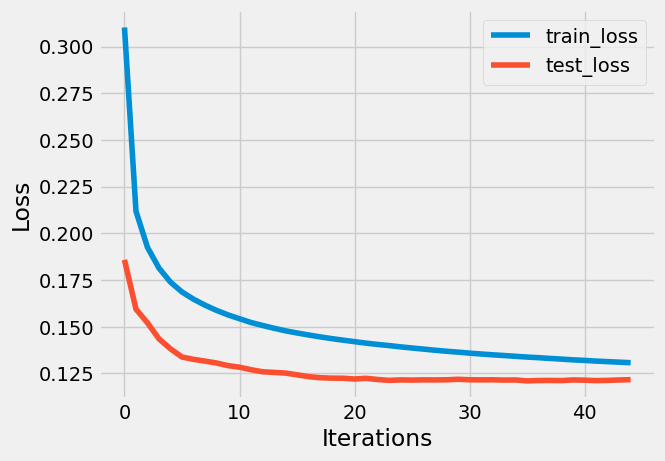

In [4]:
class Model(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        N_words = params['INPUT_WORDS_CNT']
        # N_variants = params['VARIANTS_CNT']
        N_features = params['TOTAL_WORD_FEATURES_CNT']

        # input is (N, N_words, N_features)
        # output is (N, N_words, )

        self.model = nn.Sequential(
            # nn.Flatten(2), 
            # (N, N_words, N_features + )
            # nn.TransformerEncoder(encoder_layer, num_layers=1),encoder = 
            nn.Linear(N_features, INTERNAL_EMBEDDING_SIZE),
            nn.BatchNorm1d(N_words),
            nn.ReLU(),
            
            xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),
            # xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),
            # xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),
            # xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),

            nn.Flatten(1), # (N, N_words* INTERNAL_EMBEDDING_SIZE)
            # nn.Tanh(),
            nn.Linear(N_words* INTERNAL_EMBEDDING_SIZE, params['TARGET_CLASSES_COUNT']),
            # nn.ReLU(),
            # nn.Linear(100, TARGET_CLASSES_COUNT),
            # nn.Tanh(),
            # nn.Tanhshrink(),
            # nn.Sigmoid(),
            # nn.ReLU(),
        )


    def forward(self, x):
        return self.model(x)

    # buffer_size = 0
    # for buffer in model.buffers():
    #     buffer_size += buffer.nelement() * buffer.element_size()
    # return (param_size + buffer_size) / 1024**2


aa = {}
def train_model():
    model = Model()
    print(round(count_parameters(model), 3), "Mb of parameters")
    import importlib
    import trainer_mod
    importlib.reload(trainer_mod)
    Trainer = trainer_mod.Trainer

    optimizer = torch.optim.Adam(model.parameters(), 
                            lr=1e-3)
                            # betas=(0.5, 0.999))

    trainer = Trainer(model=model, 
                    # enable_chunking=True,
                    # loss=nn.MSELoss(),
                    loss=nn.CrossEntropyLoss(),
                    optimizer=optimizer,
                    scheduler=None,
                    # scheduler=ReduceLROnPlateau(optimizer, factor=0.2, threshold=1e-5, patience=50),
                    additional_losses={
                        # "accurancy": lambda trainer: {"accurancy": 
                        #    float(torch.mean(torch.abs(trainer.model(trainer.x_test) - trainer.y_test)).detach())
                        # },
                    })

    trainer.set_data(dataset)
    try:
        trainer.train(400, trial=None, log=True) # , chunk_size=680000,
    except KeyboardInterrupt:
        print("interrupted")
        # type, val, tb = sys.exc_info()
        # traceback.clear_frames(tb)
        pass
    
    trainer.plot_history(cutoff=0)
    return trainer
import os
# os.environ["CUDA_HOME"] = "/home/misha-sh/cuda"

trainer = train_model()
# run_proc(train_model)

In [ ]:
Positional embedding должен быть около знака препинания, а не около начала

In [20]:
import __main__

for i in ["_", "__", "___", "____", "_____", "trainer", "model", "optimizer", "Out"] + \
         ["_" + str(j) for j in range(100)]:
    for j in [locals(), globals(), __main__.__dict__]:
        try:
            del j[i]
        except: pass
        for f in range(100):
            try:
                del j["_oh"][f]
            except:
                pass
import sys
try:
    sys.last_traceback.tb_next = None
except: pass

import objgraph
for i in objgraph.by_type('Trainer'):
    i.model = None
    i.x = None
    i.y = None
    i.optimizer = None
    i.x_train = None
    i.y_train = None
    i.x_test = None
    i.y_test = None
    i.dataset = None
    
import gc
# aa.clear()
gc.collect()
torch.cuda.empty_cache() 
1/0


ZeroDivisionError: division by zero

In [21]:
model = trainer.model.to('cpu:0')

from timeit import default_timer as timer
start = timer()
with torch.no_grad():
    trainer.model(trainer.dataset.x_test)
end = timer()
print(len(trainer.dataset.x_test) / (end - start) / 32, "words per sec")

_ = trainer.model.cuda()

2977.485641907047 words per sec


In [22]:
torch.save(trainer.model, "model.v1")

<AxesSubplot: >

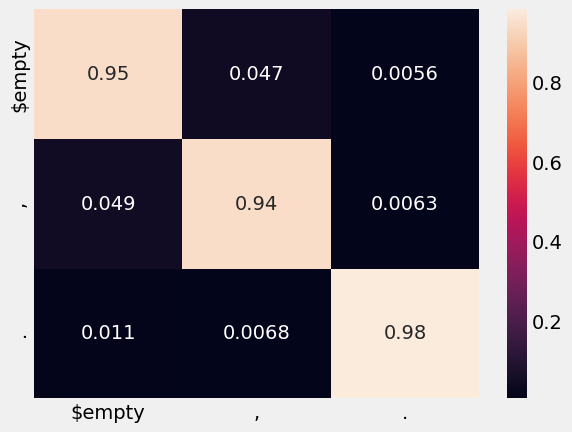

In [5]:
with torch.no_grad():
    trainer.model.eval()
    y_test_pred = trainer.model(trainer.dataset.x_test.to(trainer.device))
    _, y_pred_tags = torch.max(y_test_pred, dim = 1)
    y_pred = y_pred_tags.cpu().numpy()
    _, y_test_tags = torch.max(trainer.dataset.y_test, dim = 1)
    y_test = y_test_tags.cpu().numpy()
    
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred, normalize="true")).rename(
        columns=params['ID_TO_PUNCTUATION'], index=params['ID_TO_PUNCTUATION'])
sns.heatmap(confusion_matrix_df, annot=True)

In [15]:
morph.parse("Ивана Ивановича")

[Parse(word='ивана ивановича', tag=OpencorporaTag('NOUN,anim,masc,Patr sing,gent'), normal_form='ивана иванович', score=0.5, methods_stack=((FakeDictionary(), 'ивана ивановича', 26, 1), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'овича'))),
 Parse(word='ивана ивановича', tag=OpencorporaTag('NOUN,anim,masc,Patr sing,accs'), normal_form='ивана иванович', score=0.5, methods_stack=((FakeDictionary(), 'ивана ивановича', 26, 3), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'овича')))]

In [8]:
import shap
import scipy as sp
# https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Using%20custom%20functions%20and%20tokenizers.html
import dataset_builder
importlib.reload(dataset_builder)
trainer.model.eval()

import functools
@functools.lru_cache
def cached_word_features(tokens):
    return dataset_builder.get_word_features(tokens, params)

def inference(tokens_list):
    res = []
    features = torch.stack([
        torch.stack([cached_word_features(token) for token in tokens])
        for tokens in tokens_list])
    with torch.no_grad():
        model_pred = trainer.model(features.to(trainer.device))
        # _, val  = torch.max(model_pred, dim = 1)
        # res.append(val[0].item())
        outputs = model_pred.cpu().numpy()
        scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
        val = sp.special.logit(scores)
    return val
    # trainer.model

masker = shap.maskers.Text(dataset_builder.build_tokens, mask_token="UNDEF", collapse_mask_token=False, output_type="token_ids")

explainer = shap.Explainer(inference, masker, max_evals=100, output_names=["empty", ',', '.'])
# explainer = shap.explainers.Permutation(trainer.model, max_evals=3541)

for i in range(300, 400):
    text = dataset.texts_res[trainer.dataset.test_indices[i]]
    text_input = text.copy()
    del text_input[params['INPUT_WORDS_CNT_LEFT']]

    model_res = inference([text_input])[0]
    if np.argmax(model_res) == np.argmax(dataset.y_test[i].cpu().numpy()): 
        continue
    # if np.argmax(model_res) != 2: continue

    text = " ".join(text)
    text_input = " ".join(text_input)
    print("TARGET:", text)
    print("INPUT:", text_input)
    print("OUTPUT:", model_res)
    # print("OUTPUT:", params["ID_TO_PUNCTUATION"][model_res])
    shap_values = explainer([text_input])
    shap.plots.text(shap_values)
    print("=" * 100)
    print("=" * 100)

TARGET: В частности , эта " имитация " доступна  #$empty#  в тех же пяти цветах в которых может
INPUT: В частности , эта " имитация " доступна в тех же пяти цветах в которых может
OUTPUT: [ -5.9109464   5.9017887 -10.604474 ]


TARGET: Кроме того , отметили в понедельник в ЦИКе  #,#  со стороны " Блока Жириновского " допускаются при
INPUT: Кроме того , отметили в понедельник в ЦИКе со стороны " Блока Жириновского " допускаются при
OUTPUT: [  1.4613364  -1.461393  -11.663477 ]


TARGET: Черноморского флота РФ и с выкриками " Севастополь  #.#  Крым Россия " разбрасывавших оттуда листовки квалифицированы правоохранительными
INPUT: Черноморского флота РФ и с выкриками " Севастополь Крым Россия " разбрасывавших оттуда листовки квалифицированы правоохранительными
OUTPUT: [ 0.275293   -0.62231475 -2.410798  ]


TARGET: террористических актов против других государств илиих жителей "  #,#  и " начать сотрудничать для передачи террористовправосудию "
INPUT: террористических актов против других государств илиих жителей " и " начать сотрудничать для передачи террористовправосудию "
OUTPUT: [ 0.47581604 -0.47848794 -7.367074  ]


TARGET: с правительственными войсками один боевиксорвался в пропасть и  #,#  предположительно погиб Кроме того в одном из мест
INPUT: с правительственными войсками один боевиксорвался в пропасть и предположительно погиб Кроме того в одном из мест
OUTPUT: [ 0.4160342 -0.4166    -8.906522 ]


TARGET: может начать распродажу арестованного имущества , в частности  #,#  - 100 процентов акций компании НТВ-плюс арест на
INPUT: может начать распродажу арестованного имущества , в частности - 100 процентов акций компании НТВ-плюс арест на
OUTPUT: [ 0.8156039 -1.0212983 -3.1290925]


TARGET: Государства – члены Всемирной торговой организации в рамках  #$empty#  проходящей в Женеве сессии Генеральногосовета ВТО проголосовали за
INPUT: Государства – члены Всемирной торговой организации в рамках проходящей в Женеве сессии Генеральногосовета ВТО проголосовали за
OUTPUT: [ -2.1224983   2.1223037 -10.894277 ]


In [19]:
text = 'PAD ' * 8 + 'Мама пришла , кот съел еду'+ ' PAD' * 7
text_input = text.split()
del text_input[params['INPUT_WORDS_CNT_LEFT']]

model_res = inference([text_input])[0]

text = " ".join(text)
text_input = " ".join(text_input)
print("TARGET:", text)
print("INPUT", text_input)
print("OUTPUT:", model_res)
# print("OUTPUT:", params["ID_TO_PUNCTUATION"][model_res])
shap_values = explainer([text_input])
shap.plots.text(shap_values)

TARGET: P A D   P A D   P A D   P A D   P A D   P A D   P A D   P A D   М а м а   п р и ш л а   ,   к о т   с ъ е л   е д у   P A D   P A D   P A D   P A D   P A D   P A D   P A D
INPUT PAD PAD PAD PAD PAD PAD PAD PAD Мама пришла кот съел еду PAD PAD PAD PAD PAD PAD PAD
OUTPUT: [  3.6143982  -3.615273  -10.711602 ]


In [ ]:
# chain[1] asdf
for elem in chain[1]:
    # if "trainer_mod.Trainer" in str(chain[1][elem]) and not isinstance(chain[1][elem], str)
    if chain[2] == chain[1][elem]:
        print(elem)

for elem in chain[2]:
    if "trainer_mod.Trainer" in str(chain[2][elem]) and not isinstance(chain[2][elem], str)
    # if chain[3] == chain[2][elem]:
        print(elem)

import torch.nn as nn
import torch
def ttest():
    model = nn.Linear(100 * 100, 1).to("cuda:0")
    try:
        for i in range(1000000000):
            pass
    except KeyboardInterrupt:
        print("wer")
        pass
    a = torch.rand(100).to('cuda:0')
    return model
model = ttest()

_oh


In [ ]:
inp = nn.Flatten(2)(input[:11])

config = xFormerEncoderConfig(**encoder_config)

encoder = xFormerEncoderBlock(config)

#  Test out with dummy inputs
x = (torch.rand((10, N_words, N_variants * N_features))).abs().to(torch.float32)
y = encoder(x) # (x, x, x)
print(x.shape, y.shape)

# a = nn.TransformerEncoderLayer(d_model=N_variants *N_features,
#                                nhead=4, dim_feedforward=10, batch_first=True)
# inp.shape, a(inp).shape, count_parameters(a)

In [ ]:
aa

{}

In [ ]:
%reset_selective trainer

In [ ]:

objgraph.find_backref_chain(objgraph.by_type('Trainer')[0], objgraph.is_proper_module)[-2]

SyntaxError: cannot delete function call (3434817761.py, line 2)

In [13]:
# import objgraph
# objgraph.show_backrefs(objgraph.by_type('Trainer'), 10)

In [ ]:
from xformers.factory import xFormerEncoderBlock, xFormerEncoderConfig
N_words = INPUT_WORDS_CNT
N_variants = VARIANTS_CNT
N_features = FEATURES_CNT

INTERNAL_EMBEDDING_SIZE = 4

encoder_config = {
    "dim_model": INTERNAL_EMBEDDING_SIZE, #N_variants * N_features,
    "residual_norm_style": "pre",  # Optional, pre/post
    "position_encoding_config": {
        "name": "sine",  # whatever position encodinhg makes sense
        # "dim_model": VARIANTS_CNT * N_features,
    },
    "multi_head_config": {
        "num_heads": 4,
        "residual_dropout": 0,
        "attention": {
            "name": "scaled_dot_product", #m fourier_mix, "linformer" scaled_dot_product,  # whatever attention mechanism
            "dropout": 0, # linformer
            "seq_len": N_words, # linformer, scaled_dot_product
            "to_seq_len": N_words, # scaled_dot_product
        },
    },
    "feedforward_config": {
        "name": "MLP",
        "dropout": 0,
        "activation": "relu",
        "hidden_layer_multiplier": 1,
    },
}
# print(INTERNAL_EMBEDDING_SIZE,
#         round(count_parameters(nn.Linear(N_variants * N_features, INTERNAL_EMBEDDING_SIZE)), 4),
#         round(count_parameters(xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config))), 4), "x2 ",
#         round(count_parameters(nn.Linear(N_words* INTERNAL_EMBEDDING_SIZE, TARGET_CLASSES_COUNT)), 4),
#         "=",
#         round(count_parameters(Model()), 4))


In [ ]:
y_test, y_pred

(array([0, 2, 2, ..., 2, 0, 0]), array([0, 2, 2, ..., 1, 0, 0]))

In [ ]:
with torch.no_grad():
    model.eval()
    model.to

In [ ]:
y_test.shape, y_pred_list.shape

((167122, 3), (1, 167122))

In [ ]:
trainer.y_train

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0.])

In [ ]:
# scaler = GradScaler()

# for input, target in data:
#     with torch.autocast(device_type='cuda'):
#         output = model(input)
#         loss = loss_fn(output, target)
#     scaler.scale(loss).backward()
#     scaler.step(optimizer)
#     scaler.update()


In [ ]:


# import sys,functools, traceback
# def gpu_mem_restore(func):
#     "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
#     @functools.wraps(func)
#     def wrapper(*args, **kwargs):
#         try:
#             return func(*args, **kwargs)
#         except:
#             type, val, tb = sys.exc_info()
#             traceback.clear_frames(tb)
#             raise type(val).with_traceback(tb) from None
#     return wrapper

# @gpu_mem_restore